In [1]:
########### an plotting function given by professor #########
import pdb
import pylab as pl
import numpy as np

def plotDecisionBoundary(X, Y, scoreFn, values, title = ""):
    # Plot the decision boundary. For that, we will asign a score to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = max((x_max-x_min)/200., (y_max-y_min)/200.)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
    zz = np.array([scoreFn(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    zz = zz.reshape(xx.shape)
    pl.figure()
    CS = pl.contour(xx, yy, zz, values, colors = 'green', linestyles = 'solid', linewidths = 2)
    pl.clabel(CS, fontsize=9, inline=1)
    # Plot the training points
    pl.scatter(X[:, 0], X[:, 1], c=(1.-Y), s=50, cmap = pl.cm.cool)
    pl.title(title)
    pl.axis('tight')
    

In [2]:
########### 1. LOGISTIC REGRESSION ###########

In [3]:
from scipy.optimize import fmin_bfgs # the optimizer we tried in PA1

In [4]:
def get_path_pair(name):
    return 'data/data_{}_train.csv'.format(name), 'data/data_{}_validate.csv'.format(name) 

dataset_names = ('ls', 'nls', 'nonlin')

def get_xy(path):
    # given data format being x1, x2, y
    D = np.loadtxt(path)
    return D[:,0:2], D[:,2:3]

In [130]:
class logistic_classifier():
    
    def Wx(self, W, x):
        return W[0] + np.dot(W[1:],x)

    def set_init_W(self, x_length):
        self.W = np.ones(x_length + 1)
        
    def train(self, X, Y, lmbda):
        Y = Y.reshape(len(X))
        
        # uniformed initial guess, does not matter much though
        self.set_init_W(X.shape[1])

        # negative log likelyhood function as our loss
        NLL = lambda W: sum(np.log(1 + np.exp(- y * self.Wx(W,x))) for x,y in zip(X,Y)) + lmbda * np.linalg.norm(W[1:])**2
        
        # optimize NLL and save the weights
        self.W = fmin_bfgs(NLL, self.W, disp=0)
        
    def score(self, x):
        return 1/(1 + np.exp(- self.Wx(self.W, x)))
    
    def predit(self, x):
        return 1 if  self.score(x) > 0.5 else -1

In [131]:
def train(model, dataset, norm_penalty):
    X, Y = get_xy(dataset)
    clf = model()
    clf.train(X, Y, norm_penalty)
    return clf

In [132]:
def validate(clf, dataset_v):
    X, Y = get_xy(dataset_v)
    Y_estimate = np.array([clf.predit(x) for x in X])
    acuracy = sum(Y_estimate == Y.reshape(len(Y))) / len(Y)
    return acuracy

In [135]:
def get_accuary(model, dataset_name, norm_penalty):
    t, v = get_path_pair(dataset_name)
    clf = train(model, t, norm_penalty)
    acuracy_t = validate(clf, t)
    acuracy_v = validate(clf, v)
    print('validate: {} acuracy being {}:{} percent under norm penalty {}.'.format(dataset_name, acuracy_t*100, acuracy_v*100, norm_penalty))
    return acuracy_t, acuracy_v
    

In [136]:
def plot_logistic_regression_boundaries(model, dataset_name, norm_penalty, show=1):
    t, v = get_path_pair(dataset_name)
    clf = model()
    X_t, Y_t = get_xy(t)
    clf.train(X_t, Y_t, norm_penalty)
    title = '{} λ={} Train'.format(dataset_name.upper(),norm_penalty)
    plotDecisionBoundary(X_t, Y_t, clf.score, [0.5], title=title)
    if show:
        pl.show()
#     else:
#         pl.savefig(title)
    X_v, Y_v = get_xy(v)
    title = '{} λ={} Validate'.format(dataset_name.upper(),norm_penalty)
    plotDecisionBoundary(X_v, Y_v, clf.score, [0.5], title=title)
    if show:
        pl.show()
#     else:
#         pl.savefig(title)
    
    

In [137]:
############## 1.3 Polynomial feature expansion #############

In [138]:
# since we already have the non-expanded classifier
# we can simply expand X before train and expand u before perdict

In [139]:
from itertools import combinations as C

class logistic_classifier_expanded(logistic_classifier):
    def expand(self, x):
        expanded = np.fromiter(map(lambda x:x[0]*x[1], C(x, 2)), float)
        return np.concatenate([[1], x, expanded])
    
    def set_init_W(self, x_length):
        self.W = self.expand(np.ones(x_length))
        
    def Wx(self, W, x):
        return np.dot(W, self.expand(x))
        

In [140]:
# for n in dataset_names:
#     for p in [0,.1,.2,.5,.9,1,3,10,100]:
#         get_accuary(logistic_classifier_expanded, n, p)
#         plot_logistic_regression_boundaries(logistic_classifier_expanded,n, p,0)


In [141]:
def tune(model, dataset_name):
    lambda_range = np.arange(0, 15, .1)
    acc_range = [get_accuary(model, dataset_name, p) for p in lambda_range]
    acc_range_t = [a[0] for a in acc_range]
    acc_range_v = [a[1] for a in acc_range]

    pl.plot(lambda_range,acc_range_t)
    pl.plot(lambda_range,acc_range_v)

    pl.xlabel('λ')
    pl.ylabel('Accuracy')
    pl.legend(['train', 'validate'], loc='upper right')
    pl.savefig(dataset_name)
    pl.show()

In [264]:
# Code for generating graphs

# for n in dataset_names:
#     tune(logistic_classifier, n)
# for n in dataset_names:
#     tune(logistic_classifier_expanded, n)

In [ ]:
################# 2. SVM ##################

In [ ]:
class svm_primal:
    def train(self, X, Y, K, C):
        assert (len(X) == len(Y))
        n, m = X.shape
        
        # don't have kernal, just ignore the parameter K
        
        # parameter theta being optimized being concat(b, w, slack).T
        
        # formating constraints accordingly
        
        P = np.zeros((1+n+m, 1+n+m))
        for i in range(len(m)):
            P[i+1][i+1] = 1.0 # identity only for W
        P = matrix(P)
        q = matrix([0]+[0]*m+[C]*n) # inner producting only slack variable, use zero to ignore b and w
        
        G = np.concatenate(Y.reshape((n,1)), np.outer(x, y))
        G = matrix(-np.concatenate(G, np.eye(n)))
        h = matrix(-1.0)
        
        A = matrix(np.zeros(n, n+1), np.eye(n))
        b = matrix(0.0)
        
        theta = np.array(solvers.qp(P, q, G, h, A, b)['x']).reshape(-1)
        
        self.b = theta[0:1][0]
        self.w = theta[1:m+1]
        assert len(theta) == 1+m+n
        
    def project(self,u):
        return np.dot(self.w, u) + self.b
    
    def score(self,u):
        return self.project(u)+0.5
        
    def predict(self,u):
        return 1 if self.project(u) > 0 else -1



In [308]:
from cvxopt import matrix, solvers

solvers.options['show_progress'] = False

class svm_dual:
    def train(self, X, Y, K, C):
        assert (len(X) == len(Y))
        N = len(X)
        self.K = K # saving kernel

        X_k = np.zeros((N, N)) 
        for i in range(N):
            for j in range(N):
                X_k[i,j] = K(X[i], X[j]) # all the pairs put into kernel

        P = matrix(np.outer(Y,Y) * X_k) # outer(y,y) is the yiyj part, X_k is the xixj part
        q = matrix(-np.ones(N)) # coefficient for the `sum of a` term

        #combining two constraints into one stacked containt
        G = matrix(np.concatenate([-np.eye(N),np.eye(N)])) 
        h = matrix(np.concatenate([np.zeros(N),np.ones(N)*C]))
        
        A = matrix(y.reshape(1, N))
        b = matrix(np.zeros(1))
        
        # solve for a
        a = solvers.qp(P, q, G, h, A, b)['x'] 
        a = np.array(a).reshape(-1) # reshaping a
        
        
        # let's store the support vectors based on a
        self.sa = []
        self.sx = []
        self.sy = []
        
        for i in range(len(a)):
            if a[i] > 1e-8:
                self.sa.append(a[i])
                self.sx.append(X[i])
                self.sy.append(Y[i])
                
        # calculate and store b for prediction use
        axy = zip(self.sa,self.sx,self.sy)
        self.b = sum(self.sy[k] - sum(a*y*K(self.sx[k],x) for a,x,y in axy) for k in range(len(self.sa)))/len(self.sa)
        
    def project(self, u):
        return sum(a*y*self.K(x,u) for a,x,y in zip(self.sa,self.sx,self.sy)) + self.b
        
    def score(self, x):
        # used for ploting, not bothering changing the api while helper functions are already set up
        return self.project(x) + 0.5
            
    def predit(self, u):
        return 1 if self.project(u) > 0 else -1
        
        

In [323]:
def get_accuracy(model, dataset_name, K, C):
    t, v = get_path_pair(dataset_name)
    x,y = get_xy(t)
    clf = model()
    clf.train(x,y, K, C)
    acuracy_t = validate(clf, t)
    acuracy_v = validate(clf, v)
    print('validate: {} acuracy being {}:{} percent under C {}.'.format(dataset_name, acuracy_t*100, acuracy_v*100, C))
    return acuracy_t, acuracy_v
    
    
def draw_acc(c_range, acc_range):
    acc_range_t = [a[0] for a in acc_range]
    acc_range_v = [a[1] for a in acc_range]

    pl.plot(c_range,acc_range_t)
    pl.plot(c_range,acc_range_v)
    

def tune_svm(model, dataset_name):
    c_range = np.arange(.1, 7, .05)
    
    for k in (linear_K, polynomial_K, gaussian_K):
        draw_acc(c_range,[get_accuracy(model, dataset_name, k, p) for p in c_range])    

    pl.xlabel('C')
    pl.ylabel('Accuracy')
    pl.legend(['train_lin', 'val_lin','train_poly', 'val_poly','train_guas', 'val_gaus'], loc='upper right')
    pl.savefig(dataset_name)
    pl.show()

validate: ls acuracy being 100.0:99.5 percent under C 0.1.
validate: ls acuracy being 100.0:99.5 percent under C 0.15000000000000002.
validate: ls acuracy being 100.0:99.625 percent under C 0.20000000000000004.
validate: ls acuracy being 100.0:99.5 percent under C 0.25000000000000006.
validate: ls acuracy being 100.0:99.5 percent under C 0.30000000000000004.
validate: ls acuracy being 100.0:99.5 percent under C 0.3500000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 0.40000000000000013.
validate: ls acuracy being 100.0:99.625 percent under C 0.45000000000000007.
validate: ls acuracy being 100.0:99.625 percent under C 0.5000000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 0.5500000000000002.
validate: ls acuracy being 100.0:99.625 percent under C 0.6000000000000002.
validate: ls acuracy being 100.0:99.625 percent under C 0.6500000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 0.7000000000000002.
validate: ls acuracy being 100.

validate: ls acuracy being 100.0:99.75 percent under C 5.650000000000001.
validate: ls acuracy being 100.0:99.75 percent under C 5.700000000000001.
validate: ls acuracy being 100.0:99.5 percent under C 5.750000000000002.
validate: ls acuracy being 100.0:99.75 percent under C 5.800000000000002.
validate: ls acuracy being 100.0:99.75 percent under C 5.850000000000001.
validate: ls acuracy being 100.0:99.75 percent under C 5.900000000000001.
validate: ls acuracy being 100.0:99.75 percent under C 5.950000000000002.
validate: ls acuracy being 100.0:99.75 percent under C 6.000000000000002.
validate: ls acuracy being 100.0:99.75 percent under C 6.050000000000002.
validate: ls acuracy being 100.0:99.75 percent under C 6.100000000000001.
validate: ls acuracy being 100.0:99.5 percent under C 6.150000000000001.
validate: ls acuracy being 100.0:99.75 percent under C 6.200000000000002.
validate: ls acuracy being 100.0:99.75 percent under C 6.250000000000002.
validate: ls acuracy being 100.0:99.75 p

validate: ls acuracy being 100.0:99.625 percent under C 4.250000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 4.300000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 4.350000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 4.400000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 4.450000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 4.500000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 4.550000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 4.600000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 4.650000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 4.700000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 4.750000000000001.
validate: ls acuracy being 100.0:99.5 percent under C 4.800000000000002.
validate: ls acuracy being 100.0:99.5 percent under C 4.850000000000001.
validate: ls acuracy being 10

validate: ls acuracy being 100.0:99.5 percent under C 2.900000000000001.
validate: ls acuracy being 100.0:99.625 percent under C 2.950000000000001.
validate: ls acuracy being 100.0:99.5 percent under C 3.000000000000001.
validate: ls acuracy being 100.0:99.5 percent under C 3.050000000000001.
validate: ls acuracy being 100.0:99.5 percent under C 3.100000000000001.
validate: ls acuracy being 100.0:99.5 percent under C 3.1500000000000012.
validate: ls acuracy being 100.0:99.5 percent under C 3.200000000000001.
validate: ls acuracy being 100.0:99.5 percent under C 3.2500000000000013.
validate: ls acuracy being 100.0:99.5 percent under C 3.300000000000001.
validate: ls acuracy being 100.0:99.5 percent under C 3.350000000000001.
validate: ls acuracy being 100.0:99.5 percent under C 3.4000000000000012.
validate: ls acuracy being 100.0:99.5 percent under C 3.450000000000001.
validate: ls acuracy being 100.0:99.5 percent under C 3.5000000000000013.
validate: ls acuracy being 100.0:99.5 percent

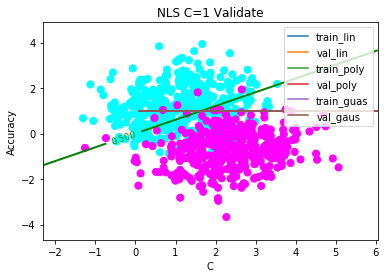

validate: nls acuracy being 88.0:83.625 percent under C 0.1.
validate: nls acuracy being 86.0:82.375 percent under C 0.15000000000000002.
validate: nls acuracy being 87.5:83.375 percent under C 0.20000000000000004.
validate: nls acuracy being 86.25:82.625 percent under C 0.25000000000000006.
validate: nls acuracy being 86.0:82.0 percent under C 0.30000000000000004.
validate: nls acuracy being 85.25:81.625 percent under C 0.3500000000000001.
validate: nls acuracy being 86.5:82.875 percent under C 0.40000000000000013.
validate: nls acuracy being 85.75:82.125 percent under C 0.45000000000000007.
validate: nls acuracy being 85.75:82.0 percent under C 0.5000000000000001.
validate: nls acuracy being 85.5:81.875 percent under C 0.5500000000000002.
validate: nls acuracy being 86.5:82.875 percent under C 0.6000000000000002.
validate: nls acuracy being 86.25:82.625 percent under C 0.6500000000000001.
validate: nls acuracy being 85.25:81.625 percent under C 0.7000000000000002.
validate: nls acura

validate: nls acuracy being 87.25:83.25 percent under C 5.550000000000002.
validate: nls acuracy being 87.25:83.25 percent under C 5.600000000000001.
validate: nls acuracy being 87.25:83.25 percent under C 5.650000000000001.
validate: nls acuracy being 85.75:82.25 percent under C 5.700000000000001.
validate: nls acuracy being 87.25:83.25 percent under C 5.750000000000002.
validate: nls acuracy being 87.25:83.125 percent under C 5.800000000000002.
validate: nls acuracy being 87.25:83.25 percent under C 5.850000000000001.
validate: nls acuracy being 87.25:83.25 percent under C 5.900000000000001.
validate: nls acuracy being 87.25:83.25 percent under C 5.950000000000002.
validate: nls acuracy being 87.25:83.25 percent under C 6.000000000000002.
validate: nls acuracy being 87.25:83.25 percent under C 6.050000000000002.
validate: nls acuracy being 87.25:83.25 percent under C 6.100000000000001.
validate: nls acuracy being 87.25:83.25 percent under C 6.150000000000001.
validate: nls acuracy be

validate: nls acuracy being 90.0:88.625 percent under C 4.100000000000001.
validate: nls acuracy being 90.0:88.625 percent under C 4.150000000000001.
validate: nls acuracy being 90.0:88.625 percent under C 4.200000000000001.
validate: nls acuracy being 90.0:88.625 percent under C 4.250000000000001.
validate: nls acuracy being 90.0:88.625 percent under C 4.300000000000001.
validate: nls acuracy being 90.0:88.625 percent under C 4.350000000000001.
validate: nls acuracy being 90.0:88.625 percent under C 4.400000000000001.
validate: nls acuracy being 90.5:88.5 percent under C 4.450000000000001.
validate: nls acuracy being 90.5:88.5 percent under C 4.500000000000001.
validate: nls acuracy being 90.0:88.5 percent under C 4.550000000000001.
validate: nls acuracy being 90.0:88.5 percent under C 4.600000000000001.
validate: nls acuracy being 89.5:86.25 percent under C 4.650000000000001.
validate: nls acuracy being 89.5:86.5 percent under C 4.700000000000001.
validate: nls acuracy being 89.5:86.

validate: nls acuracy being 92.25:91.125 percent under C 2.700000000000001.
validate: nls acuracy being 92.5:91.125 percent under C 2.750000000000001.
validate: nls acuracy being 92.5:91.0 percent under C 2.800000000000001.
validate: nls acuracy being 92.5:91.125 percent under C 2.850000000000001.
validate: nls acuracy being 92.5:91.125 percent under C 2.900000000000001.
validate: nls acuracy being 92.5:91.0 percent under C 2.950000000000001.
validate: nls acuracy being 92.5:91.0 percent under C 3.000000000000001.
validate: nls acuracy being 92.5:91.0 percent under C 3.050000000000001.
validate: nls acuracy being 92.5:91.125 percent under C 3.100000000000001.
validate: nls acuracy being 92.5:91.125 percent under C 3.1500000000000012.
validate: nls acuracy being 92.5:91.125 percent under C 3.200000000000001.
validate: nls acuracy being 92.5:91.125 percent under C 3.2500000000000013.
validate: nls acuracy being 92.5:91.125 percent under C 3.300000000000001.
validate: nls acuracy being 92

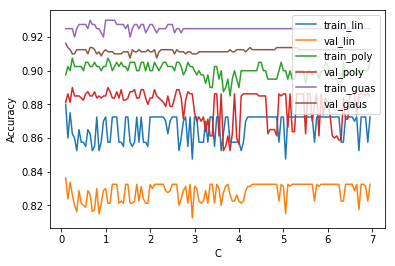

validate: nonlin acuracy being 81.0:78.875 percent under C 0.1.
validate: nonlin acuracy being 81.5:79.0 percent under C 0.15000000000000002.
validate: nonlin acuracy being 82.0:79.875 percent under C 0.20000000000000004.
validate: nonlin acuracy being 81.75:80.25 percent under C 0.25000000000000006.
validate: nonlin acuracy being 81.75:80.125 percent under C 0.30000000000000004.
validate: nonlin acuracy being 80.75:79.25 percent under C 0.3500000000000001.
validate: nonlin acuracy being 82.0:80.125 percent under C 0.40000000000000013.
validate: nonlin acuracy being 82.75:80.5 percent under C 0.45000000000000007.
validate: nonlin acuracy being 82.75:80.625 percent under C 0.5000000000000001.
validate: nonlin acuracy being 81.0:79.75 percent under C 0.5500000000000002.
validate: nonlin acuracy being 82.75:80.625 percent under C 0.6000000000000002.
validate: nonlin acuracy being 82.75:80.5 percent under C 0.6500000000000001.
validate: nonlin acuracy being 82.0:80.375 percent under C 0.70

validate: nonlin acuracy being 81.0:79.625 percent under C 5.350000000000001.
validate: nonlin acuracy being 81.0:79.375 percent under C 5.400000000000001.
validate: nonlin acuracy being 82.75:80.625 percent under C 5.450000000000001.
validate: nonlin acuracy being 82.75:80.625 percent under C 5.500000000000002.
validate: nonlin acuracy being 81.0:79.5 percent under C 5.550000000000002.
validate: nonlin acuracy being 81.0:79.75 percent under C 5.600000000000001.
validate: nonlin acuracy being 81.25:80.0 percent under C 5.650000000000001.
validate: nonlin acuracy being 81.25:80.0 percent under C 5.700000000000001.
validate: nonlin acuracy being 81.25:80.0 percent under C 5.750000000000002.
validate: nonlin acuracy being 81.25:80.0 percent under C 5.800000000000002.
validate: nonlin acuracy being 81.25:80.0 percent under C 5.850000000000001.
validate: nonlin acuracy being 81.25:80.0 percent under C 5.900000000000001.
validate: nonlin acuracy being 81.25:80.0 percent under C 5.95000000000

validate: nonlin acuracy being 93.25:92.375 percent under C 3.7000000000000015.
validate: nonlin acuracy being 93.25:92.5 percent under C 3.7500000000000013.
validate: nonlin acuracy being 93.25:92.5 percent under C 3.800000000000001.
validate: nonlin acuracy being 93.25:92.125 percent under C 3.8500000000000014.
validate: nonlin acuracy being 93.25:92.125 percent under C 3.9000000000000012.
validate: nonlin acuracy being 93.25:92.625 percent under C 3.9500000000000015.
validate: nonlin acuracy being 94.5:92.375 percent under C 4.000000000000001.
validate: nonlin acuracy being 93.5:92.25 percent under C 4.050000000000002.
validate: nonlin acuracy being 93.0:92.875 percent under C 4.100000000000001.
validate: nonlin acuracy being 93.5:92.25 percent under C 4.150000000000001.
validate: nonlin acuracy being 93.5:92.375 percent under C 4.200000000000001.
validate: nonlin acuracy being 93.5:92.375 percent under C 4.250000000000001.
validate: nonlin acuracy being 93.25:92.375 percent under C

validate: nonlin acuracy being 81.5:82.125 percent under C 2.0500000000000007.
validate: nonlin acuracy being 81.5:81.875 percent under C 2.100000000000001.
validate: nonlin acuracy being 77.75:76.375 percent under C 2.150000000000001.
validate: nonlin acuracy being 81.5:81.75 percent under C 2.2000000000000006.
validate: nonlin acuracy being 81.5:81.75 percent under C 2.250000000000001.
validate: nonlin acuracy being 76.5:75.0 percent under C 2.3000000000000007.
validate: nonlin acuracy being 81.0:81.125 percent under C 2.350000000000001.
validate: nonlin acuracy being 81.25:81.75 percent under C 2.400000000000001.
validate: nonlin acuracy being 81.25:81.5 percent under C 2.450000000000001.
validate: nonlin acuracy being 81.25:81.5 percent under C 2.500000000000001.
validate: nonlin acuracy being 81.0:80.75 percent under C 2.5500000000000007.
validate: nonlin acuracy being 81.25:81.25 percent under C 2.600000000000001.
validate: nonlin acuracy being 81.5:81.375 percent under C 2.65000

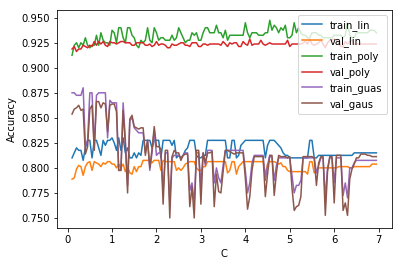

In [324]:

# generating the graphs for showing effects of tuning over C
for n in dataset_names:
    tune_svm(svm_dual, n)


In [311]:
linear_K = np.dot

def polynomial_K(x1, x2, p=2):
    return (1 + np.dot(x1, x2)) ** p

def gaussian_K(x1, x2, sigma=1):
    return np.exp(-np.linalg.norm(x1-x2)**2 / (2*(sigma**2)))

In [335]:
def plot_svm_boundaries(model, dataset_name, K, C):
    t, v = get_path_pair(dataset_name)
    clf = model()
    X_t, Y_t = get_xy(t)
    clf.train(X_t, Y_t, K, C)
    title = '{} C={} Train'.format(dataset_name.upper(),C)
    plotDecisionBoundary(X_t, Y_t, clf.score, [0.5], title=title)
    pl.show()
    X_v, Y_v = get_xy(v)
    title = '{} C={} Validate'.format(dataset_name.upper(),C)
    plotDecisionBoundary(X_v, Y_v, clf.score, [0.5], title=title)
    pl.savefig('nonlin_linear_K')
    pl.show()
    

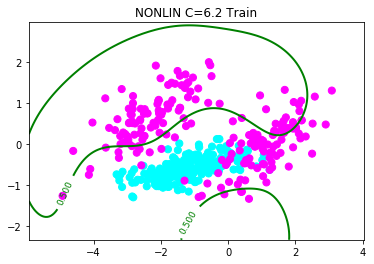

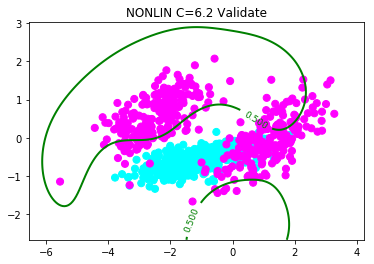

In [336]:
# generating graph for decision boundary
plot_svm_boundaries(svm_dual, 'nonlin', gaussian_K, 6.2)


In [329]:
def tune_sigma(model, dataset_name):
    c_range = np.arange(.1, 7, .05)
    
    draw_acc(c_range,[get_accuracy(model, dataset_name, lambda x1,x2: gaussian_K(x1, x2, sigma=sigma), 1) for sigma in c_range])    

    pl.xlabel('σ')
    pl.ylabel('Accuracy')
    pl.legend(['train_lin', 'val_lin','train_poly', 'val_poly','train_guas', 'val_gaus'], loc='upper right')
    pl.savefig(dataset_name)
    pl.show()

validate: nonlin acuracy being 97.0:91.375 percent under C 1.
validate: nonlin acuracy being 96.75:91.5 percent under C 1.
validate: nonlin acuracy being 95.75:92.0 percent under C 1.
validate: nonlin acuracy being 94.25:91.625 percent under C 1.
validate: nonlin acuracy being 94.0:91.5 percent under C 1.
validate: nonlin acuracy being 93.5:91.25 percent under C 1.
validate: nonlin acuracy being 93.0:90.875 percent under C 1.
validate: nonlin acuracy being 92.75:90.5 percent under C 1.
validate: nonlin acuracy being 92.5:90.5 percent under C 1.
validate: nonlin acuracy being 92.25:90.5 percent under C 1.
validate: nonlin acuracy being 92.5:90.5 percent under C 1.
validate: nonlin acuracy being 92.0:90.25 percent under C 1.
validate: nonlin acuracy being 91.75:89.5 percent under C 1.
validate: nonlin acuracy being 92.25:90.5 percent under C 1.
validate: nonlin acuracy being 89.5:88.375 percent under C 1.
validate: nonlin acuracy being 90.25:88.875 percent under C 1.
validate: nonlin acu

validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0 percent under C 1.
validate: nonlin acuracy being 50.0:50.0

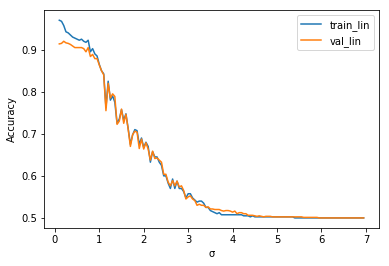

In [334]:
# generating the graphs for showing effects of tuning over C
# for n in dataset_names:
tune_sigma(svm_dual, 'nonlin')


In [333]:
pl.show()